## Subspaces learned by different methods

In this example, we analyze subspaces learned by different methods: Difference-in-Mean and Rank-1 ReFT (`LsReFT`).

#### Set-ups

In [78]:
import torch, json, random, einops
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from umap import UMAP
from plotnine import (
    ggplot, aes, geom_point, facet_wrap, theme_minimal, theme,
    element_rect, element_line, element_blank, element_text,
    scale_color_manual, geom_density, scale_fill_manual
)

from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoModelForCausalLM, 
    AutoTokenizer, 
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import matplotlib.pyplot as plt

In [20]:
def load_jsonl(jsonl_path):
    """
    Load data from a JSON lines file.
    """
    jsonl_data = []
    with open(jsonl_path, 'r') as f:
        for line in f:
            data = json.loads(line)
            jsonl_data += [data]
    return jsonl_data

def get_genre(metadata_entry):
    """
    Returns the genre string ('text', 'code', or 'math').
    """
    concept_name = metadata_entry['concept']
    return metadata_entry['concept_genres_map'][concept_name][0]

def get_logits(model, tokenizer, concept_subspace, k=10):
    top_logits, neg_logits = [None], [None]

    W_U = model.lm_head.weight.T
    W_U = W_U * (model.model.norm.weight +
                torch.ones_like(model.model.norm.weight))[:, None]
    W_U -= einops.reduce(
        W_U, "d_model d_vocab -> 1 d_vocab", "mean"
    )

    vocab_logits = concept_subspace @ W_U
    top_values, top_indices = vocab_logits.topk(k=k, sorted=True)
    top_tokens = tokenizer.batch_decode(top_indices.unsqueeze(dim=-1))
    top_logits = [list(zip(top_tokens, top_values.tolist()))]
    
    neg_values, neg_indices = vocab_logits.topk(k=k, largest=False, sorted=True)
    neg_tokens = tokenizer.batch_decode(neg_indices.unsqueeze(dim=-1))
    neg_logits = [list(zip(neg_tokens, neg_values.tolist()))]

    return top_logits, neg_logits

In [67]:
model = "2b"
layer = "l20"

In [68]:
lsreft = torch.load(f"../results/prod_{model}_{layer}_concept16k_lsreft/train/LsReFT_weight.pt")
lsreft_metadata = load_jsonl(f"../results/prod_{model}_{layer}_concept16k_lsreft/train/metadata.jsonl")
assert lsreft.shape[0] == len(lsreft_metadata)

diffmean = torch.load(f"../results/prod_{model}_{layer}_concept16k_diffmean/train/DiffMean_weight.pt")
diffmean_metadata = load_jsonl(f"../results/prod_{model}_{layer}_concept16k_diffmean/train/metadata.jsonl")
assert diffmean.shape[0] == len(diffmean_metadata)
assert lsreft.shape[0] == diffmean.shape[0]

#### Check unembeds

We can follow unembed the learned subspace to output tokens, and get top ranked tokens that are related to the learned subspace for each method.

In [5]:
# Load the interpreting model
model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it", torch_dtype=torch.bfloat16)
_ = model.cuda()
tokenizer = AutoTokenizer.from_pretrained(
    "google/gemma-2-2b-it", model_max_length=512)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
# Get a random subspace and its label
concept_id = random.randint(0, diffmean.shape[0] - 1)
concept_id

5267

In [10]:
concept_subspace = diffmean[concept_id].cuda()
print("Concept:", diffmean_metadata[concept_id]["concept"])
get_logits(model, tokenizer, concept_subspace, k=5)

Concept: references to product quality and advertising concepts


([[(' brand', 0.8984375),
   (' quality', 0.8203125),
   (',', 0.74609375),
   (' captivating', 0.73828125),
   (' excellence', 0.734375)]],
 [[(' Houſe', -1.09375),
   (' ſche', -1.0703125),
   (' Majefty', -1.0625),
   (' houſe', -1.0625),
   (' Jefus', -1.0625)]])

In [18]:
diffmean_metadata[0]

{'concept_id': 0,
 'concept': 'references to rental services and associated equipment',
 'ref': 'https://www.neuronpedia.org/gemma-2-2b/20-gemmascope-res-16k/16038',
 'concept_genres_map': {'references to rental services and associated equipment': ['text']}}

In [11]:
concept_subspace = lsreft[concept_id].cuda()
print("Concept:", lsreft_metadata[concept_id]["concept"])
get_logits(model, tokenizer, concept_subspace, k=5)

Concept: references to product quality and advertising concepts


([[(' advertising', 1.28125),
   (' marketing', 1.21875),
   (' brand', 1.1015625),
   (' product', 1.09375),
   (' quality', 1.0859375)]],
 [[(' juridiques', -0.671875),
   (' affitto', -0.625),
   (' honte', -0.62109375),
   (' suivants', -0.5859375),
   (' montón', -0.58203125)]])

They actually ended up having very similar topk token sets. Tokens like `honte` and ` houſe` are also very alike and both are in the negative sets.

#### Check clusters

Let's see how subspaces are clustered for our methods.

In [ ]:
# Run UMAP for each embedding set separately (so no overlap in each UMAP space)
umap_lsreft = UMAP(n_components=2, random_state=42).fit_transform(lsreft.float().numpy())
umap_diffmean = UMAP(n_components=2, random_state=42).fit_transform(diffmean.float().numpy())

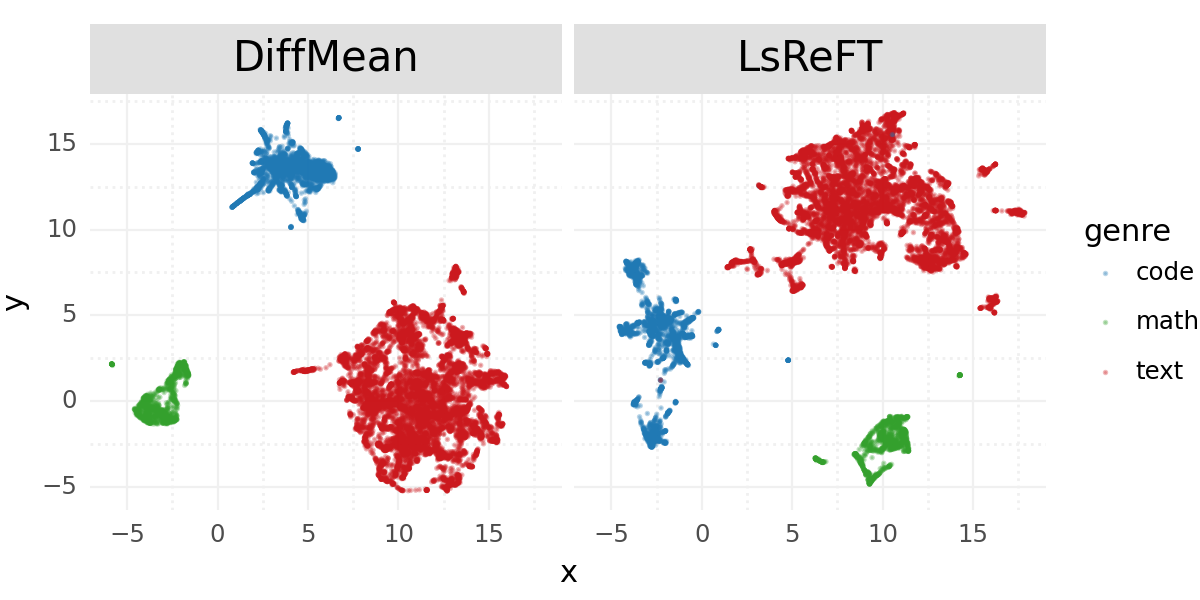

In [71]:
df_lsreft = pd.DataFrame({
    'x': umap_lsreft[:, 0],
    'y': umap_lsreft[:, 1],
    'genre': [get_genre(m) for m in lsreft_metadata],
    'method': 'LsReFT'
})
df_diffmean = pd.DataFrame({
    'x': umap_diffmean[:, 0],
    'y': umap_diffmean[:, 1],
    'genre': [get_genre(m) for m in diffmean_metadata],
    'method': 'DiffMean'
})
df_all = pd.concat([df_lsreft, df_diffmean], ignore_index=True)

genre_palette = {
    'text': '#CB181D',  # red
    'code': '#1F78B4',  # blue
    'math': '#33A02C',  # green
}

plot = (
    ggplot(df_all, aes('x', 'y', color='genre'))
    + geom_point(size=0.1, alpha=0.3)  # fully opaque
    + facet_wrap('~method')
    + scale_color_manual(values=genre_palette)
    + theme_minimal()
    + theme(
        figure_size=(6, 3),    
        plot_margin=0.0,
        strip_background=element_rect(fill="#E0E0E0", color=None, linewidth=0.00),
        strip_text=element_text(size=15, color="black"),
        panel_border=element_blank(),
        panel_grid_major=element_line(color="#F0F0F0"),
        panel_grid_minor=element_line(color="#F0F0F0", linetype='dotted'),
    )
)

print(plot)

To interact with our UMAP, check `subspace_gazer.ipynb`!

#### Check cosine similarity between subspaces learned by two methods

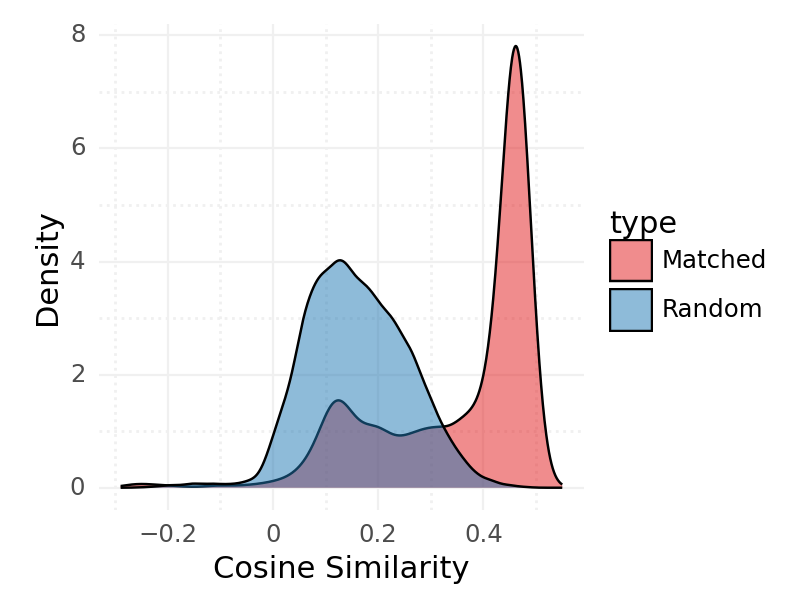

In [79]:
n = lsreft.shape[0]
row_match_cosine = F.cosine_similarity(lsreft.float(), diffmean.float(), dim=1).numpy()
random_indices = torch.randperm(n)
random_cosine = F.cosine_similarity(lsreft.float(), diffmean[random_indices].float(), dim=1).numpy()

df = pd.DataFrame({
    'cosine': list(row_match_cosine) + list(random_cosine),
    'type':   ['Matched'] * n       + ['Random'] * n
})

fill_palette = {
    'Matched': '#e31a1c',  # or pick your preferred colors
    'Random':  '#1f78b4'
}

plot = (
    ggplot(df, aes('cosine', fill='type'))
    + geom_density(alpha=0.5)
    + scale_fill_manual(values=fill_palette)
    + labs(
        x="Cosine Similarity",
        y="Density"
    )
    + theme_minimal()
    + theme(
        figure_size=(4, 3),
        aspect_ratio=1.0,
        # Remove panel border
        panel_border=element_blank(),
        panel_grid_major=element_line(color="#F0F0F0"),
        panel_grid_minor=element_line(color="#F0F0F0", linetype='dotted'),
        strip_background=element_rect(fill="#E0E0E0", color=None),
        strip_text=element_text(size=10, color="black"),
    )
)

print(plot)
# If you want to save to file:
# plot.save("cosine_similarity_distribution.png", dpi=300)